In [1]:
import sys
from os.path import join
sys.path.insert(0, join('..', 'CHIP-Network-Model'))
sys.path.insert(0, 'utils')

import numpy as np
import matplotlib.pyplot as plt
from plotting_utils import heatmap
from scipy.sparse.linalg import svds
import generative_model_utils as utils
import model_fitting_utils as fitting_utils
import parameter_estimation as estimate_utils
from spectral_clustering import spectral_cluster
import sbm
import chip

## Load data and show summary statistics

In [2]:
data_file_name = join('data', 'facebook-wall-filtered.txt')
(data_event_dict, data_num_nodes, data_duration) = chip.load_facebook_chip(
    data_file_name, timestamp_max=1000)
print(f"Number of nodes: {data_num_nodes:,}")
print(f"Number of events: {utils.num_events_in_event_dict(data_event_dict):,}")
print("Duration of the network:", data_duration)

Number of nodes: 1,985
Number of events: 112,057
Duration of the network: 1000.0


## Estimate cluster memberships using spectral clustering

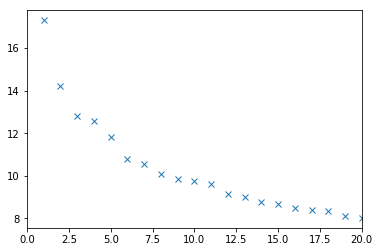

Enter the number of clusters: 2
[ 173 1812]


In [3]:
adj = utils.event_dict_to_adjacency(data_num_nodes, data_event_dict)
node_membership = sbm.spectralCluster(adj, directed=True)
num_classes = np.max(node_membership) + 1
cluster_sizes = np.histogram(node_membership, bins=num_classes)[0]
print(cluster_sizes)

### Re-order nodes by class memberships and re-examine adjacency matrix

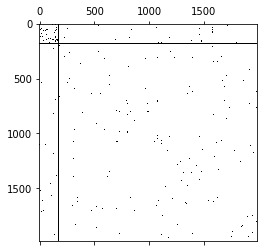

In [4]:
sbm.spyClusters(adj, node_membership)

## Estimate Hawkes process parameters

In [5]:
agg_adj = utils.event_dict_to_aggregated_adjacency(data_num_nodes, data_event_dict)
(bp_mu, bp_alpha, bp_beta, bp_m) = fitting_utils.estimate_bp_hawkes_params(
    data_event_dict, node_membership, data_duration, num_classes, agg_adj)
print(bp_mu)
print(bp_m)
print(bp_alpha)
print(bp_beta)

[[6.15551865e-05 3.73583736e-06]
 [2.88170389e-06 4.20957937e-06]]
[[0.81455542 0.782849  ]
 [0.77182495 0.85118855]]
[[0.01366213 0.00986823]
 [0.00932092 0.01235674]]
[[0.0167725  0.01260553]
 [0.01207647 0.01451705]]


### Event counts per block pair

(<matplotlib.image.AxesImage at 0x7f3121a30748>,
 <matplotlib.colorbar.Colorbar at 0x7f3121b43358>)

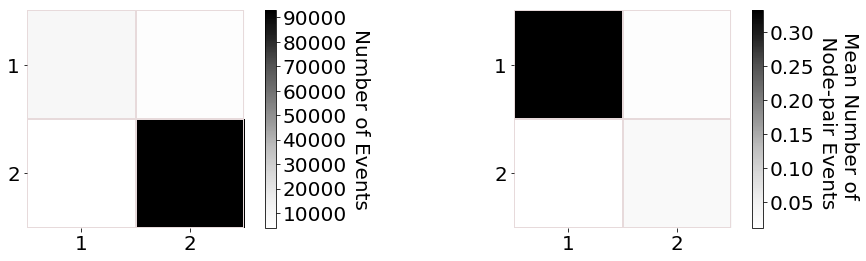

In [6]:
block_pair_events = utils.event_dict_to_block_pair_events(data_event_dict, node_membership, num_classes)
bp_size = utils.calc_block_pair_size(node_membership, num_classes)

labels = np.arange(1, num_classes + 1)

num_events_block_pair = np.zeros((num_classes, num_classes), dtype=np.int)
for i in range(num_classes):
    for j in range(num_classes):
        if len(block_pair_events[i][j]) > 0:
            num_events_block_pair[i, j] = len(np.concatenate(block_pair_events[i][j]))
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
heatmap(num_events_block_pair, labels, labels, ax=axes[0], 
        cmap="Greys", color_bar_format='%d', cbarlabel="Number of Events")
heatmap(num_events_block_pair / bp_size, labels, labels, ax=axes[1], 
        cmap="Greys", color_bar_format='%.2f', cbarlabel="Mean Number of \n Node-pair Events")

### Estimated CHIP model parameters

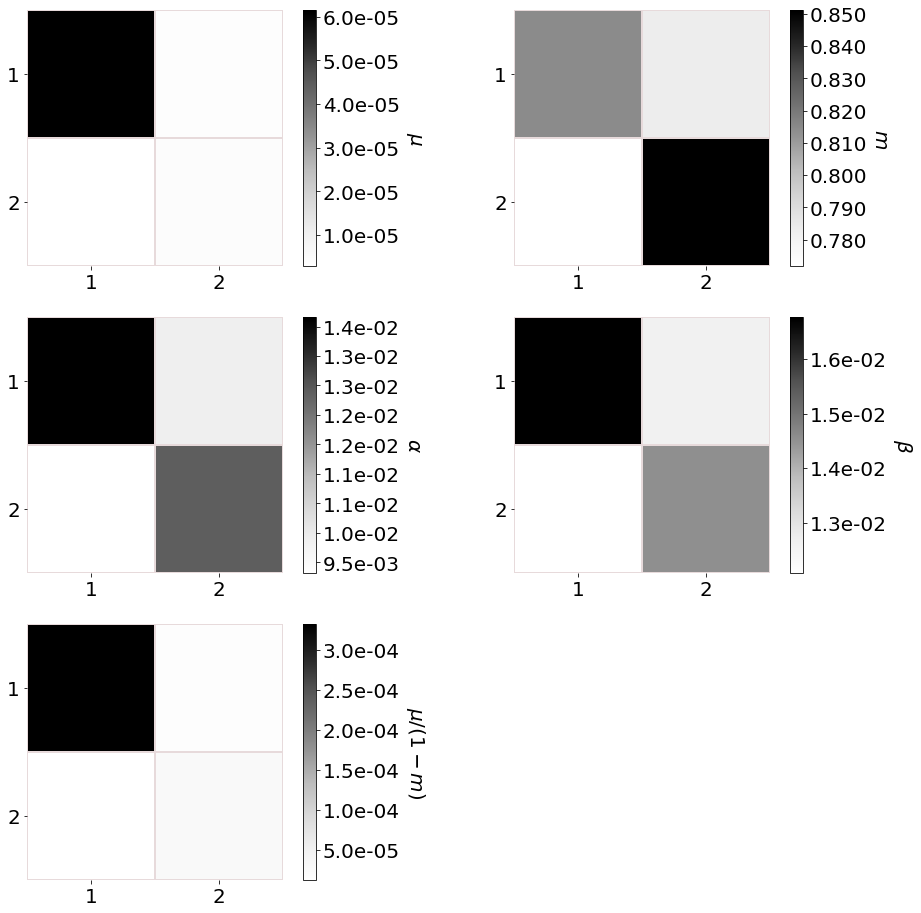

In [7]:
labels = np.arange(1, num_classes + 1)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
heatmap(bp_mu, labels, labels, ax=axes[0, 0], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\mu$")
heatmap(bp_m, labels, labels, ax=axes[0, 1], cmap="Greys", color_bar_format='%.3f', cbarlabel=r"$m$")
heatmap(bp_alpha, labels, labels, ax=axes[1, 0], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\alpha$")
heatmap(bp_beta, labels, labels, ax=axes[1, 1], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\beta$")
heatmap(bp_mu / (1 - bp_m), labels, labels, ax=axes[2, 0], cmap="Greys", color_bar_format='%.1e', 
        cbarlabel=r"$\mu / (1-m)$")
axes[2, 1].remove()

### Confidence intervals for estimated m for each block pair

In [8]:
significance_level = 0.05
_, m_ci = fitting_utils.compute_mu_and_m_confidence_interval(data_event_dict, node_membership, num_classes, 
                                                             z_alpha=significance_level, duration=data_duration)
for a in range(num_classes):
    for b in range(num_classes):
        print(f"({a + 1}, {b + 1}): {bp_m[a, b]:.3f} +/- {m_ci[a, b]:.3f}")

(1, 1): 0.815 +/- 0.014
(1, 2): 0.783 +/- 0.019
(2, 1): 0.772 +/- 0.022
(2, 2): 0.851 +/- 0.004
